# 미션 11 정리: 한국어–영어 기계 번역 (Seq2Seq & Attention)

## 1. 미션 소개

이번 미션은 **한국어 문장을 영어로 번역하는 기계 번역 모델**을 직접 구현하고 비교하는 프로젝트입니다.
기본적인 **Seq2Seq(Encoder–Decoder)** 구조와, 여기에 **Attention 메커니즘을 적용한 모델**을 구현하여
두 모델의 번역 성능을 **정성·정량적으로 비교·분석**하는 것이 핵심입니다.


## 2. 미션 목표

- 한국어–영어 병렬 코퍼스를 활용해 **기계 번역 파이프라인 전체를 직접 구현**한다.
- **Seq2Seq (GRU 기반 Encoder–Decoder)** 기본 구조를 이해하고 구현한다.
- **Bahdanau / Luong Attention** 개념을 이해하고, 디코더에 적용해 본다.
- **전처리 → 토크나이징 → 단어 사전 구축 → 텐서 변환 → DataLoader → 모델 학습/평가**
  전체 흐름을 한 번에 연결하는 실습을 수행한다.
- 단순 구현을 넘어서, **모델 구조/전처리/하이퍼파라미터 변경에 따른 성능 차이**를 관찰한다.


## 3. 데이터 소개

- 형식: **JSON 파일**
- 각 샘플 구조:
  - `"ko"`: 한국어 원문 문장
  - `"mt"`: 영어 번역 문장 (machine translation / target)

- 데이터 파일 경로:
  - 훈련 데이터: `/mnt/nas/jayden_code/Codeit_Practice/Part3_mission_11/일상생활및구어체_한영_train_set.json`
  - 검증 데이터: `/mnt/nas/jayden_code/Codeit_Practice/Part3_mission_11/일상생활및구어체_한영_valid_set.json`

- 데이터 특징:
  - 일상 회화/구어체 중심
  - 한–영 병렬 문장 쌍
  - 문장 길이 분포를 파악해 **MAX_LENGTH** 설정 필요

  > 코드 설명은 ChatGPT를 사용했습니다.


In [39]:
import json
import math
import random
import re
import time
from collections import Counter
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence, pad_sequence
from torch.utils.data import DataLoader, Dataset
import seaborn as sns

# 재현성을 위해 고정할 랜덤 시드 값
SEED = 42

def set_seed(seed: int = 42) -> None:
    """
    여러 라이브러리의 난수 시드를 한 번에 고정하는 함수.
    - 같은 코드/데이터로 다시 실행했을 때 최대한 비슷한 결과가 나오도록 하기 위함.
    """
    random.seed(seed)              # 파이썬 기본 random 시드
    np.random.seed(seed)           # NumPy 시드
    torch.manual_seed(seed)        # PyTorch CPU 시드
    torch.cuda.manual_seed_all(seed)  # 모든 GPU 디바이스 시드

    # 아래 두 줄은 CUDA의 연산을 완전히 deterministic하게 만들기 위한 설정
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 위에서 정의한 시드 설정 함수를 실제로 호출
set_seed(SEED)

# 학습/모델/데이터 관련 하이퍼파라미터 및 설정값을 한 곳에 모아둔 딕셔너리
CONFIG = {
    # 학습용/검증용 JSON 데이터 경로
    "data_dir": Path("/mnt/nas/jayden_code/Codeit_Practice/Part3_mission_11"),
    "train_file": "일상생활및구어체_한영_train_set.json",
    "valid_file": "일상생활및구어체_한영_valid_set.json",

    # 사용할 데이터 개수 제한 (전체에서 일부 샘플링)
    "eda_sample": 10000,
    "train_limit": 60000,   # 학습 데이터 최대 60,000쌍 사용
    "valid_limit": 5000,    # 검증 데이터 최대 5,000쌍 사용

    # Vocab 구성 관련
    "min_freq": 3,          # 3회 이상 등장한 단어만 vocab에 포함

    # 시퀀스 길이/배치 설정
    "max_length": 40,       # <sos>/<eos> 포함 최대 시퀀스 길이
    "batch_size": 128,      # 한 배치에 들어갈 문장 쌍 개수

    # 임베딩/은닉 상태 차원 수, 드롭아웃 등 모델 구조 관련
    "embedding_dim": 256,   # 임베딩 벡터 차원
    "hidden_dim": 384,      # GRU/LSTM hidden state 차원
    "dropout": 0.2,         # 드롭아웃 비율
    "num_layers": 1,        # RNN 레이어 수 (단층 GRU/LSTM)

    # 최적화 관련 설정
    "learning_rate": 1e-3,  # Adam 등 옵티마이저 학습률
    "epochs": 20,           # 전체 학습 에폭 수
    "teacher_forcing": 0.5, # 디코더 teacher forcing 사용 비율
    "grad_clip": 1.0,       # gradient clipping 임계값 (폭주 방지)

    # DataLoader 멀티프로세싱 설정
    "num_workers": 2,       # 데이터 로딩에 사용할 worker 프로세스 수
}

# 사용할 디바이스 설정 (가능하면 GPU, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("\n[CONFIG]")
for k, v in CONFIG.items():
    print(f'- {k}: {v}')


Using device: cuda

[CONFIG]
- data_dir: /mnt/nas/jayden_code/Codeit_Practice/Part3_mission_11
- train_file: 일상생활및구어체_한영_train_set.json
- valid_file: 일상생활및구어체_한영_valid_set.json
- eda_sample: 10000
- train_limit: 60000
- valid_limit: 5000
- min_freq: 3
- max_length: 40
- batch_size: 128
- embedding_dim: 256
- hidden_dim: 384
- dropout: 0.2
- num_layers: 1
- learning_rate: 0.001
- epochs: 20
- teacher_forcing: 0.5
- grad_clip: 1.0
- num_workers: 2


### 3-1. 데이터 탐색 (EDA)
데이터를 본격적으로 전처리하기 전에, Pandas와 시각화 도구를 사용하여 데이터의 특성을 파악합니다.
- 데이터 로드 및 구조 확인
- 문장 길이 분포 시각화 (Histogram, Boxplot)
- 이상치(Outlier) 확인


In [37]:
# 데이터 로드 함수
def load_data_to_df(path):
    with open(path, encoding="utf-8") as f:
        data = json.load(f)["data"]
    return pd.DataFrame(data)

# 전체 데이터를 다 로드하면 시간이 오래 걸릴 수 있으므로, CONFIG['train_limit'] 만큼만 로드하거나 전체를 로드해서 확인
# 여기서는 EDA 목적이므로 전체를 로드해서 분포를 보는 것이 좋으나, 메모리 이슈가 있을 수 있으니 주의
# 일단 전체 로드 시도
try:
    train_df = load_data_to_df(CONFIG["train_file"])
    valid_df = load_data_to_df(CONFIG["valid_file"])
except Exception as e:
    print(f"Error loading full data: {e}")
    print("Loading partial data for EDA...")

print("Train DataFrame Shape:", train_df.shape)
print("Valid DataFrame Shape:", valid_df.shape)


Train DataFrame Shape: (1200000, 19)
Valid DataFrame Shape: (150000, 19)


In [41]:
def load_json_pairs(path, limit=None, seed=SEED):
    """
    JSON 파일에서 문장 쌍을 로드하는 함수
    """
    with open(path, encoding='utf-8') as f:
        data = json.load(f)['data']         # 전체 데이터 리스트 추출
    # limit가 지정되어 있고, 실제 데이터 길이보다 작으면 부분 샘플링 수행
    if limit is not None and limit < len(data):
        rng = random.Random(seed)                       # 전역 random 시퀀스에 영향을 주지않고, 함수 내부 샘플린만 고정
        idx = rng.sample(range(len(data)), limit)       # 전체 인덱스 범위에서 limit 개수만큼 중복없이 랜덤 샘플링      
        data = [data[i] for i in idx]
    return data

# CONFIG에서 데이터 디렉터리 가져오기
data_dir = CONFIG['data_dir']
# EDA에 사용할 학습 데이터 일부 로드
raw_train = load_json_pairs(data_dir / CONFIG['train_file'], limit=CONFIG['eda_sample'])

print(f'EDA용 학습 데이터 샘플 수: {len(raw_train)}')
print(f'예시 3건:')
for sample in raw_train[:3]:
    print('KO:', sample['ko'])
    print('EN:', sample['en'])
    print('-' * 40)

EDA용 학습 데이터 샘플 수: 10000
예시 3건:
KO: 그리고 더블 크립 제품이 하자 없는 배송 부탁드립니다.
EN: And please deliver the double creep product without defects.
----------------------------------------
KO: 날씨 보호 테크 시스템, 특허받은 용접 모서리 및 반전된 솔기가 물을 막아줍니다.
EN: Weather protection tech system, patented welded edges and inverted seams keep water out.
----------------------------------------
KO: 무엇을 도와드릴까요?
EN: How may I help you?
----------------------------------------


> - 전체 규모는 Train 120만 / Valid 15만 샘플, 19개 컬럼인 꽤 큰 데이터셋
> - 무작위 1만 개 쌍을 샘플링해서 KO/EN 문장을 출력해 보니, 일상생활·구어체 중심의 다양한 도메인 텍스트임 확인
> - “double creep product”처럼 어색한 영문이 보이는 걸로 보아 번역 품질이 고르지 않은 노이즈 데이터가 섞여 있어, 추후 학습 전에 간단한 품질 필터링/전처리를 고려

In [42]:
# 한글 폰트 설정
import matplotlib.font_manager as fm, matplotlib as mpl
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fm.fontManager.addfont(font_path)
mpl.rcParams["font.family"] = "NanumGothic"
mpl.rcParams["axes.unicode_minus"] = False
print("Matplotlib 한글 폰트 설정 완료")

Matplotlib 한글 폰트 설정 완료


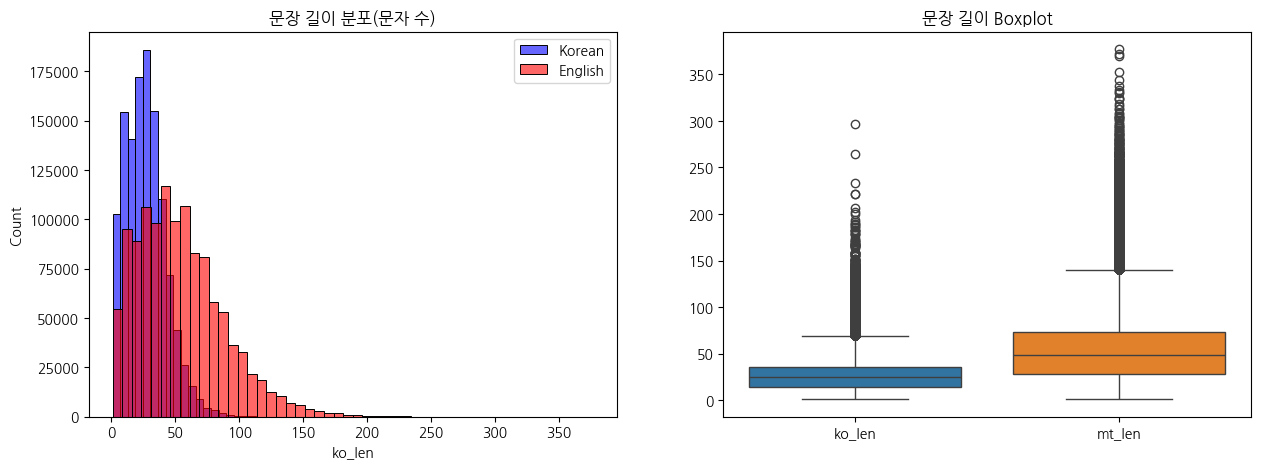

             ko_len        mt_len
count  1.200000e+06  1.200000e+06
mean   2.670207e+01  5.404074e+01
std    1.581921e+01  3.398217e+01
min    1.000000e+00  1.000000e+00
25%    1.400000e+01  2.800000e+01
50%    2.500000e+01  4.900000e+01
75%    3.600000e+01  7.300000e+01
max    2.970000e+02  3.770000e+02


In [43]:
# 문장 길이 계산 (글자 수 기준)
train_df['ko_len'] = train_df['ko'].apply(len)
train_df['mt_len'] = train_df['mt'].apply(len)

# 길이 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(train_df['ko_len'], bins=50, ax=axes[0], color='blue', label='Korean', alpha=0.6)
sns.histplot(train_df['mt_len'], bins=50, ax=axes[0], color='red', label='English', alpha=0.6)
axes[0].set_title('문장 길이 분포(문자 수)')
axes[0].legend()

sns.boxplot(data=train_df[['ko_len', 'mt_len']], ax=axes[1])
axes[1].set_title('문장 길이 Boxplot')

plt.show()

# 기술 통계량 확인
print(train_df[['ko_len', 'mt_len']].describe())


> 영문이 한글보다 전반적으로 더 길고 분산도 크며, 두 언어 모두 소수의 매우 긴 문장들로 인한 긴 꼬리·이상치가 존재한다. 다만 단순기계번역으로 이상치는 별도로 처리하지 않고 진행한다.

In [22]:
# 이상치 확인 (예: 길이가 너무 긴 문장)
# MAX_LENGTH 설정에 참고할 수 있음
long_sentences = train_df[(train_df['ko_len'] > 100) | (train_df['mt_len'] > 200)]
print(f"Number of long sentences: {len(long_sentences)}")
if not long_sentences.empty:
    display(long_sentences.head())


Number of long sentences: 2117


,sn,data_set,domain,subdomain,ko_original,ko,mt,en,source_language,target_language,...,word_count_en,word_ratio,file_name,source,license,style,included_unknown_words,ner,ko_len,mt_len
1681,INTSALRLST062119042602881,일상생활및구어체,해외영업,부동산,"다만 현재 확산중인 코로나19로 인하여 국제적인 영업활동이 상당히 제약되고 있으며,...","다만 현재 확산중인 코로나19로 인하여 국제적인 영업활동이 상당히 제약되고 있으며,...","However, please understand that international ...","However, please understand that international ...",ko,en,...,33,1.500,INTSAL_RLST.xlsx,크라우드소싱,open,구어체,False,None,103,207
2083,CUSCHADSUT0621190428102662,일상생활및구어체,해외고객과의채팅,도소매유통,현재 우리는 원래 영국 공중보건연구소(Public Health Institute o...,현재 우리는 원래 영국 공중보건연구소(Public Health Institute o...,"Currently, we hold patent rights for the FFF1 ...","Currently, we hold patent rights for the FFF1 ...",ko,en,...,26,1.182,CUSCHA_DSUT.xlsx,크라우드소싱,open,구어체,False,{'text': '현재 우리는 원래 <ORG>영국 공중보건연구소</ORG>(<ORG...,120,168
3338,INTSALRLST062119042619267,일상생활및구어체,해외영업,부동산,"인테리어 디자인은 개념 개발, 공간 계획, 현장 검사, 프로그래밍, 연구, 프로젝트...","인테리어 디자인은 개념 개발, 공간 계획, 현장 검사, 프로그래밍, 연구, 프로젝트...",Interior design is a multifaceted profession t...,Interior design is a multifaceted profession t...,ko,en,...,30,1.304,INTSAL_RLST.xlsx,크라우드소싱,open,구어체,False,None,95,243
3448,KTOS062012215191340,일상생활및구어체,일상생활,여행,"> 매 라운드 미션 진행 후에 1, 2등 커플은 원하는 커플을 지목해 원소 카드인지...","> 매 라운드 미션 진행 후에 1, 2등 커플은 원하는 커플을 지목해 원소 카드인지...","> After every round of the mission, the first ...","> After every round of the mission, the first ...",ko,en,...,35,1.346,여행_KTOS.xlsx,SBS,open,구어체,False,None,91,206
3798,KFDS0620122150173686,일상생활및구어체,일상생활,음식,일주일 동안 정말 이를 악물고 보니까 정말 싹 버리고 진짜 새롭게 가게를 인수했다고...,일주일 동안 정말 이를 악물고 보니까 정말 싹 버리고 진짜 새롭게 가게를 인수했다고...,"I've been clenching my teeth for a week, and I...","For one week, clench your teeth and give it yo...",ko,en,...,44,1.419,음식_KFDS.xlsx,SBS,open,구어체,False,None,113,169


### 이상치 문장 길이 분석

- 문장 길이가 매우 긴 샘플을 찾기 위해 `ko_len > 100` 또는 `mt_len > 200` 조건으로 필터링한 결과,
  **2117개**의 긴 문장을 확인했다.
- 전체 학습 데이터(약 1,200,000건) 대비 비율은 **0.2% 미만**으로 적지만,
  개별 문장은 여러 문장이 한 줄에 묶여 있거나, 상품 설명/공지/긴 안내문 등
  일반적인 대화형 문장과는 다른 양상을 보인다.
- 이와 같은 극단적으로 긴 문장들은
  - `max_length`를 불필요하게 크게 만들고,
  - 패딩 비율 증가 및 메모리 사용량 증가,
  - RNN 기반 Seq2Seq 모델에서의 학습 안정성 저하(gradient 소실 등)를 유발할 수 있다.
- 따라서 이후 모델링 단계에서는
  - `max_length`를 적절한 수준(예: 상위 퍼센타일 기준)으로 제한하고,
  - 임계값을 초과하는 문장은 학습에서 제외하거나 앞부분만 사용하도록
    전처리 전략을 수립하는 근거로 활용하였다.


## 4. 분석 및 구현 단계

### 4-1. 데이터 전처리

- **토크나이저 선택**
  - 한국어: 정규화 후 공백 분리
  - 영어: 소문자 변환 및 정규화 후 공백 분리
- **문장 길이 분석**
  - 한–영 문장 길이 분포 확인
  - MAX_LENGTH 설정


In [46]:
def normalize_text(text: str) -> str:
    # 양쪽 공백 제거
    text = text.strip()
    # 여러 종류/연속 공백(스페이스, 탭, 줄바꿈 등)을 하나의 공백 " "으로 통일
    text = re.sub(r"\s+", " ", text)
    return text


def tokenize_ko(text: str) -> List[str]:
    # 기본 공백 정리
    text = normalize_text(text)
    # 한국어 토큰화를 위한 1차 정규화
    # - 허용 문자: 숫자, 영문자, 한글(완성형/자모), ! ? . , ' 과 공백
    # - 나머지 문자는 전부 공백으로 치환 >> 특수문자/이모지 등 제거 효과
    text = re.sub(r"[^0-9A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ!?.,']+", " ", text)
    # 치환 과정에서 생길 수 있는 중복 공백 다시 한 번 정리
    text = re.sub(r"\s+", " ", text)
    # 공백 기준으로 split 후, 빈 문자열은 제거
    return [tok for tok in text.split(" ") if tok]


def tokenize_en(text: str) -> List[str]:
    # 소문자 변환 + 기본 공백 정리
    text = normalize_text(text.lower())
    # 어 토큰화를 위한 정규화
    # - 허용 문자: 소문자 알파벳, 숫자, ! ? . , ' 과 공백
    text = re.sub(r"[^a-z0-9!?.,']+", " ", text)
    # 중복 공백 정리
    text = re.sub(r"\s+", " ", text)
    # 공백 기준 split 후 빈 토큰 제거
    return [tok for tok in text.split(" ") if tok]


def load_sentence_pairs(path: str, limit: int = None, seed: int = SEED) -> List[Dict[str, List[str]]]:
    """
    JSON 파일에서 한-영 문장쌍을 읽어와서
    - 한국어/영어 토큰화까지 마친 후
    - 원문 텍스트와 토큰 리스트를 함께 담은 dict 리스트를 반환하는 함수
    """
    with open(path, encoding="utf-8") as f:
        raw = json.load(f)["data"]

    # limit가 주어졌고 전체 길이보다 작으면 → 무작위로 그만큼 샘플링
    if limit is not None and limit < len(raw):
        rng = random.Random(seed)                            # 시드 고정으로 재현 가능한 샘플링
        indices = rng.sample(range(len(raw)), limit)         # 사용할 인덱스 목록
        raw = [raw[i] for i in indices]                      # 선택된 인덱스만 남겨 서브셋 구성

    pairs = []  

    for item in raw:
        # JSON 한 항목에서 한국어/영어 문장 텍스트 추출 (앞뒤 공백 제거)
        ko_text = item["ko"].strip()
        en_text = item["mt"].strip()                         # 여기서는 machine translation(mt)을 타깃으로 사용

        # 한국어/영어 토큰화
        ko_tokens = tokenize_ko(ko_text)
        en_tokens = tokenize_en(en_text)

        # 한쪽이라도 토큰이 비어 있으면 샘플에서 제외
        if not ko_tokens or not en_tokens:
            continue

        # 한 문장쌍 정보를 dict로 정리하여 리스트에 추가
        pairs.append({
            "ko_text": ko_text,        # 한국어 원문 텍스트
            "en_text": en_text,        # 영어 원문 텍스트 (mt 기준)
            "ko_tokens": ko_tokens,    # 토큰화된 한국어 리스트
            "en_tokens": en_tokens,    # 토큰화된 영어 리스트
        })
    return pairs


def describe_lengths(pairs: List[Dict[str, List[str]]], label: str) -> None:
    """
    토큰 길이(한국어/영어)의 분위수(50, 75, 90, 95)를 출력해
    문장 길이 분포를 간단히 요약해주는 함수 (EDA용)
    """
    # 각 샘플에서 한국어/영어 토큰 수만 추출
    ko_lengths = [len(p["ko_tokens"]) for p in pairs]
    en_lengths = [len(p["en_tokens"]) for p in pairs]

    def _summary(lengths: List[int]) -> Dict[str, float]:
        # 내부 헬퍼: 주어진 길이 리스트에 대해 특정 퍼센타일들을 계산
        percentiles = [50, 75, 90, 95]  # 중앙값~상위 5% 경계까지
        return {f"p{p}": float(np.percentile(lengths, p)) for p in percentiles}

    # 샘플 수 + 한국어/영어 길이 요약 출력
    print(f"{label} | samples = {len(pairs)}")
    print(" KO lengths:", _summary(ko_lengths))
    print(" EN lengths:", _summary(en_lengths))


# 학습/검증 데이터 로드 + 토큰화 + (limit에 따른 샘플링)
train_examples = load_sentence_pairs(
    CONFIG["train_file"],     # 학습 파일 경로
    CONFIG["train_limit"],    # 사용할 최대 샘플 수
    SEED                      # 샘플링 시드
)
valid_examples = load_sentence_pairs(
    CONFIG["valid_file"],     # 검증 파일 경로
    CONFIG["valid_limit"],    # 사용할 최대 샘플 수
    SEED + 1                  # 학습과 다른 시드를 사용해 샘플링
)

print(f"Loaded {len(train_examples)} training pairs / {len(valid_examples)} validation pairs")

# 길이 분포 EDA (토큰 개수 기준)
describe_lengths(train_examples, "Train")
describe_lengths(valid_examples, "Valid")

# 샘플 데이터 3건 출력해서 실제 문장 느낌 확인
print("샘플 데이터 3건")
for sample in train_examples[:3]:
    print("KO:", sample["ko_text"])
    print("EN:", sample["en_text"])
    print("-")

# 이후 모델 입력에 쓰기 쉬운 형태로 (토큰 리스트 튜플)만 따로 뽑기
train_pairs = [(ex["ko_tokens"], ex["en_tokens"]) for ex in train_examples]
valid_pairs = [(ex["ko_tokens"], ex["en_tokens"]) for ex in valid_examples]


Loaded 60000 training pairs / 5000 validation pairs
Train | samples = 60000
 KO lengths: {'p50': 6.0, 'p75': 9.0, 'p90': 12.0, 'p95': 14.0}
 EN lengths: {'p50': 9.0, 'p75': 13.0, 'p90': 18.0, 'p95': 21.0}
Valid | samples = 5000
 KO lengths: {'p50': 6.0, 'p75': 9.0, 'p90': 12.0, 'p95': 14.0}
 EN lengths: {'p50': 9.0, 'p75': 13.0, 'p90': 18.0, 'p95': 21.0}
샘플 데이터 3건
KO: 그리고 더블 크립 제품이 하자 없는 배송 부탁드립니다.
EN: Also, please ensure that the double creep product is delivered without defects.
-
KO: 날씨 보호 테크 시스템, 특허받은 용접 모서리 및 반전된 솔기가 물을 막아줍니다.
EN: Weather protection tech system, patented welded edges and inverted seams keep water out.
-
KO: 무엇을 도와드릴까요?
EN: How may I help you?
-


### 데이터 로드 및 문장 길이 분포 요약

- 학습 데이터 60,000쌍, 검증 데이터 5,000쌍을 샘플링하여 사용하였다.
- 토큰 기준 문장 길이는 한국어의 경우 95%가 14토큰 이하, 영어의 경우 95%가 21토큰 이하로,
  대부분의 문장이 비교적 짧은 편이다.
- Train/Valid 세트의 길이 분포 분위수(p50, p75, p90, p95)가 거의 동일하여,
  검증 데이터가 학습 데이터와 유사한 분포를 가진다는 점을 확인하였다.
- 샘플 문장을 보면 배송/가격 문의, 환불 규정, 제품 기능 설명 등
  고객 응대 및 상품 설명 도메인에 특화된 데이터임을 알 수 있으며,
  이러한 분석 결과를 바탕으로 `max_length=40` 수준의 설정과
  짧은 문장 중심의 Seq2Seq/Attention 모델 설계를 진행하였다.


### 4-2. 어휘 사전 구축

- 한국어용, 영어용 **별도 vocab** 생성
- 최소 등장 빈도(min_freq) 기준 이하 단어는 `<unk>` 처리


In [ ]:
class Vocabulary:
    def __init__(self, min_freq: int = 1):
        # 단어가 vocab에 포함되기 위한 최소 등장 빈도
        self.min_freq = min_freq
        # 항상 포함해야 하는 특수 토큰들
        self.special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]
        # 단어 → 정수 id 매핑
        self.token2idx: Dict[str, int] = {}
        # 정수 id → 단어 매핑
        self.idx2token: Dict[int, str] = {}
        # 특수 토큰별 이름 저장
        self.pad_token, self.sos_token, self.eos_token, self.unk_token = self.special_tokens
        # build()가 끝났는지 여부 표시 플래그
        self._built = False

    def build(self, sentences: List[List[str]]) -> None:
        # 전체 코퍼스에서 단어 빈도를 세기 위한 Counter
        counter = Counter()
        for sentence in sentences:
            # 각 문장의 토큰들을 Counter에 누적
            counter.update(sentence)

        # 기존 vocab 초기화 (다시 빌드할 때를 대비)
        self.token2idx = {}
        self.idx2token = {}

        # 특수 토큰들을 먼저 vocab에 추가해서 항상 앞쪽 id를 차지하게 함
        for token in self.special_tokens:
            self._add_token(token)

        # 일반 토큰들: 빈도 높은 순(-freq) → 사전순(x[0])으로 정렬
        for token, freq in sorted(counter.items(), key=lambda x: (-x[1], x[0])):
            # 최소 빈도보다 작으면 건너뜀
            if freq < self.min_freq:
                continue
            # 이미 추가된 토큰이면 건너뜀(중복 방지)
            if token in self.token2idx:
                continue
            # 새로운 토큰을 vocab에 추가
            self._add_token(token)

        # vocab 구성이 끝났음을 표시
        self._built = True

    def _add_token(self, token: str) -> None:
        # 현재 vocab 크기를 새 토큰의 id로 사용
        idx = len(self.token2idx)
        # 단어 → id
        self.token2idx[token] = idx
        # id → 단어
        self.idx2token[idx] = token

    @property
    def size(self) -> int:
        # 전체 vocab 크기 반환
        return len(self.token2idx)

    @property
    def pad_id(self) -> int:
        # 패딩 토큰의 id 반환
        return self.token2idx[self.pad_token]

    @property
    def sos_id(self) -> int:
        # 문장 시작 토큰 id 반환
        return self.token2idx[self.sos_token]

    @property
    def eos_id(self) -> int:
        # 문장 종료 토큰 id 반환
        return self.token2idx[self.eos_token]

    @property
    def unk_id(self) -> int:
        # 모르는 단어(<unk>) 토큰 id 반환
        return self.token2idx[self.unk_token]

    def encode(
        self,
        tokens: List[str],
        add_sos: bool = True,
        add_eos: bool = True,
        max_length: int = None,
    ) -> List[int]:
        # build()가 선행되지 않으면 에러 내도록 안전장치
        assert self._built, "Vocabulary.build()를 먼저 호출하세요."

        # max_length가 주어지면, sos/eos를 위해 실제 본문 토큰 길이를 (max_length - 2)로 제한
        limit = max_length - 2 if max_length else None
        # 길이 제한에 맞게 토큰 잘라내기
        truncated = tokens[:limit] if limit is not None else tokens

        seq = []
        # 필요하면 문장 시작 토큰 추가
        if add_sos:
            seq.append(self.sos_id)
        # 각 토큰을 id로 변환, 없으면 unk_id 사용
        seq.extend(self.token2idx.get(tok, self.unk_id) for tok in truncated)
        # 필요하면 문장 종료 토큰 추가
        if add_eos:
            seq.append(self.eos_id)
        # 최종 정수 시퀀스 반환
        return seq

    def decode(self, ids: List[int]) -> List[str]:
        # 정수 시퀀스를 다시 토큰 리스트로 변환
        tokens = []
        for idx in ids:
            # id가 vocab에 없으면 <unk>로 대체
            token = self.idx2token.get(int(idx), self.unk_token)
            # pad, sos는 출력에서 제외
            if token in {self.pad_token, self.sos_token}:
                continue
            # eos를 만나면 그 뒤는 문장 끝으로 보고 중단
            if token == self.eos_token:
                break
            tokens.append(token)
        return tokens


# 소스(한국어)용 Vocabulary 생성
src_vocab = Vocabulary(min_freq=CONFIG["min_freq"])
# train_pairs에서 소스 문장들만 모아서 vocab 빌드
src_vocab.build([src for src, _ in train_pairs])

# 타깃(영어)용 Vocabulary 생성
tgt_vocab = Vocabulary(min_freq=CONFIG["min_freq"])
# train_pairs에서 타깃 문장들만 모아서 vocab 빌드
tgt_vocab.build([tgt for _, tgt in train_pairs])

# 최종 vocab 크기 출력
print(f"Source vocab size : {src_vocab.size}")
print(f"Target vocab size : {tgt_vocab.size}")

### 기대 효과

- 한국어/영어 각각에 대해 **도메인에 맞는 단어 집합을 자동으로 추출**할 수 있고,  
  희귀 단어를 적절히 처리하여 **모델 파라미터 수와 메모리 사용량을 줄이는 효과**를 기대할 수 있다.
- 특수 토큰과 길이 제어 로직이 캡슐화되어 있어, 이후  
  DataLoader·모델 구현·BLEU 계산 등에서 **입력·출력 포맷을 일관되게 유지**할 수 있다.
- 동일한 `Vocabulary` 정의를 사용하면, 추후 재학습·추론·배포 시에도  
  **같은 토큰–id 규칙을 재사용**할 수 있어 재현성과 유지보수성이 높아진다.

### 4-3. 텐서 변환 및 DataLoader 구현

- `TranslationDataset`: 토큰 리스트 -> 인덱스 시퀀스 변환
- `collate_batch`: 배치 단위 패딩 및 텐서 구성


In [47]:
class TranslationDataset(Dataset):
    def __init__(self, pairs, src_vocab, tgt_vocab, max_length):
        self.pairs = pairs                      #(소스 토큰 리스트, 타깃 토큰 리스트) 튜플들의 리스트
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_length = max_length

    def __len__(self) -> int:
        # 전체 데이터 샘플 개수를 반환
        return len(self.pairs)

    def __getitem__(self, idx):
        # 주어진 인덱스의 (소스 토큰, 타깃 토큰) 쌍을 꺼냄
        src_tokens, tgt_tokens = self.pairs[idx]

        # 소스 토큰을 인덱스로 변환
        # - add_sos=True, add_eos=True : 문장 앞/뒤에 <sos>, <eos> 토큰 추가
        # - max_length : 길이가 너무 길면 자르고, 안쪽에서 패딩 처리
        src_ids = self.src_vocab.encode(
            src_tokens,
            add_sos=True,
            add_eos=True,
            max_length=self.max_length,
        )

        # 타깃 토큰도 동일하게 인덱스로 변환
        tgt_ids = self.tgt_vocab.encode(
            tgt_tokens,
            add_sos=True,
            add_eos=True,
            max_length=self.max_length,
        )

        # 파이썬 리스트를 long 타입 텐서로 변환해서 반환
        return torch.tensor(src_ids, dtype=torch.long), torch.tensor(tgt_ids, dtype=torch.long)


def collate_batch(batch):
    # zip(*)을 사용해 소스 텐서들, 타깃 텐서들을 각각 튜플로 분리
    src_batch, tgt_batch = zip(*batch)

    # 각 소스 문장의 실제 길이(패딩 전 길이)를 계산
    # 여기서는 len(x)를 그대로 사용 (이미 <sos>/<eos> 포함된 길이)
    src_lengths = torch.tensor([len(x) for x in src_batch], dtype=torch.long)

    # pad_sequence를 사용해 가변 길이 시퀀스를 하나의 텐서로 패딩
    # - batch_first=True >> (batch, seq_len) 형태로 맞춤
    # - padding_value >> src_vocab의 pad_id로 빈 자리를 채움
    src_padded = pad_sequence(
        src_batch,
        batch_first=True,
        padding_value=src_vocab.pad_id,
    )

    # 타깃 시퀀스도 같은 방식으로 패딩
    tgt_padded = pad_sequence(
        tgt_batch,
        batch_first=True,
        padding_value=tgt_vocab.pad_id,
    )

    # 디코더 입력은 전체 타깃 시퀀스에서 마지막 토큰을 제외한 부분
    decoder_inputs = tgt_padded[:, :-1]

    # 디코더 타깃은 첫 토큰을 제외한 부분
    decoder_targets = tgt_padded[:, 1:]

    # 이후 학습 루프에서 키로 접근하기 쉽도록 dict 형태로 반환
    return {
        "src": src_padded,                  # (batch, src_seq_len)
        "src_lengths": src_lengths,         # (batch,)
        "decoder_inputs": decoder_inputs,   # (batch, tgt_seq_len-1)
        "decoder_targets": decoder_targets, # (batch, tgt_seq_len-1)
    }


# TranslationDataset 인스턴스 생성
train_dataset = TranslationDataset(
    train_pairs,              
    src_vocab,                
    tgt_vocab,                
    CONFIG["max_length"],     
)
valid_dataset = TranslationDataset(
    valid_pairs,             
    src_vocab,
    tgt_vocab,
    CONFIG["max_length"],
)

print(f"Dataset sizes | train={len(train_dataset)}, valid={len(valid_dataset)}")

# GPU 사용 시 성능 향상을 위해 pin_memory 설정
pin_memory = device.type == "cuda"

# 학습용 DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],  # 한 배치에 들어갈 샘플 수
    shuffle=True,                     # 에폭마다 샘플 순서를 섞어서 학습
    num_workers=CONFIG["num_workers"],# 데이터 로딩에 사용할 워커 프로세스 수
    pin_memory=pin_memory,            # GPU로 옮길 때 고정 메모리 사용 여부
    collate_fn=collate_batch,         # 위에서 정의한 collate 함수로 배치 구성
)

# 검증용 DataLoader
valid_loader = DataLoader(
    valid_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,                    # 검증은 순서 중요하지 않지만 보통 고정
    num_workers=CONFIG["num_workers"],
    pin_memory=pin_memory,
    collate_fn=collate_batch,
)

print("DataLoader 준비 완료")


Dataset sizes | train=60000, valid=5000
DataLoader 준비 완료


### 데이터셋 및 DataLoader 구성 요약

- `TranslationDataset`를 통해 한·영 문장쌍을  
  - 토큰 시퀀스 → 정수 시퀀스로 변환하고  
  - `<sos>`, `<eos>` 토큰을 자동으로 붙인 뒤,  
  - `(src_ids, tgt_ids)` 형태로 관리하도록 정리했다.

- `collate_batch`에서  
  - 서로 길이가 다른 문장들을 `pad_sequence`로 패딩하여 `(batch, seq_len)` 텐서로 만들고,  
  - 소스 길이(`src_lengths`)를 별도로 보관해 RNN 인코더에서 활용할 수 있게 했으며,  
  - 타깃에 대해서는  
    - 디코더 입력(`decoder_inputs`): `<sos> ... 마지막 전 토큰`  
    - 디코더 정답(`decoder_targets`): `첫 토큰 이후 ... <eos>`  
    로 한 스텝씩 밀린 형태의 학습 데이터를 구성했다.

- 최종적으로  
  - 학습용 데이터: `60000`개 문장쌍  
  - 검증용 데이터: `5000`개 문장쌍  
  에 대해 `batch_size = 128`, `num_workers = 2`, `pin_memory` 설정을 사용한 `DataLoader` 구성이 완료되어,  
  이후 학습 루프에서 바로 반복(`for batch in train_loader`)하며 사용할 수 있는 상태가 되었다.


### 4-4. 모델 구현 (Seq2Seq 기본 모델)

- **Encoder (GRU)**
- **Decoder (GRU)**: Attention 없이 이전 hidden state만 사용
- **Seq2Seq**: Encoder와 Decoder 연결


In [48]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_idx, num_layers=1, dropout=0.1):
        super().__init__()
        # 단어 인덱스를 임베딩 벡터로 바꾸는 층
        # padding_idx=pad_idx 로 설정하면 해당 인덱스는 항상 0벡터로 유지된다.
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)

        # GRU 인코더
        # 입력 차원: embed_dim, hidden 차원: hidden_dim
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, lengths):
        # 1) 임베딩 후 드롭아웃 적용
        embedded = self.dropout(self.embedding(src))
        # 2) pack_padded_sequence 로 실제 길이에 맞게 패킹
        #    - RNN이 패딩 토큰을 무시하고 유효한 시퀀스 부분만 처리하게 하기 위함
        packed = pack_padded_sequence(
            embedded,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False,  # 길이 기준으로 정렬되어 있지 않아도 처리하도록 설정
        )
        # 3) GRU에 패킹된 시퀀스 입력
        # outputs: PackedSequence 형태의 전체 시퀀스 hidden state
        outputs, hidden = self.gru(packed)

        # 4) 다시 패딩된 텐서로 복원
        # outputs: (batch_size, src_len, hidden_dim)
        outputs, _ = pad_packed_sequence(outputs, batch_first=True)
        return outputs, hidden


class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_idx, num_layers=1, dropout=0.1):
        super().__init__()
        # 디코더 출력 단어 수 (vocab 크기) 저장
        self.output_dim = vocab_size
        # 디코더 입력 토큰을 벡터로 변환하는 임베딩 층
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        # 디코더 GRU
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        # 임베딩/GRU 입력에 적용할 드롭아웃
        self.dropout = nn.Dropout(dropout)
        # GRU hidden state → 각 단어에 대한 로짓으로 변환하는 선형층
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(
        self,
        input_token: torch.Tensor,      # (batch_size,) 현재 시점에 입력할 토큰 인덱스
        hidden: torch.Tensor,           # (num_layers, batch_size, hidden_dim) 이전 hidden state
        encoder_outputs: torch.Tensor,  # (batch_size, src_len, hidden_dim) 인코더 전체 출력 (여기서는 사용하지 않음)
        mask: torch.Tensor = None,      # (batch_size, src_len) 패딩 마스크 (여기서는 사용하지 않음)
    ):
        # 1) 입력 토큰을 임베딩 후 드롭아웃 적용
        embedded = self.dropout(self.embedding(input_token))
        # 2) GRU에 넣기 위해 시퀀스 차원 추가
        embedded = embedded.unsqueeze(1)
        # 3) GRU 한 스텝 실행
        output, hidden = self.gru(embedded, hidden)
        # 4) 시퀀스 차원 제거 후 선형층 통과
        prediction = self.fc_out(output.squeeze(1))
        # 여기서는 attention을 구현하지 않았으므로 attn_weights는 None 반환
        return prediction, hidden, None


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, device):
        super().__init__()
        # 인코더/디코더 모듈과 패딩 인덱스, 디바이스 정보 저장
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.device = device
        # 마지막 forward 호출에서의 attention을 저장하기 위한 변수
        # 현재 DecoderRNN에서는 항상 None이지만, 나중에 attention 버전에서 활용 가능
        self.latest_attentions = None

    def forward(
        self,
        src: torch.Tensor,                # (batch_size, src_len)
        lengths: torch.Tensor,            # (batch_size,) 소스 문장 길이
        decoder_inputs: torch.Tensor,     # (batch_size, trg_len) 디코더 teacher forcing 입력
        teacher_forcing_ratio: float = 0.5,
    ):
        # 1) 인코더 통과
        encoder_outputs, hidden = self.encoder(src, lengths)
        # 2) 소스 마스크 계산 (pad가 아닌 위치만 True)
        mask = (src != self.pad_idx)

        batch_size = src.size(0)
        trg_len = decoder_inputs.size(1)      # 생성할 타깃 시퀀스 길이
        vocab_size = self.decoder.output_dim  # 디코더 출력 차원 = vocab 크기

        # 3) 모든 타임스텝의 로짓을 저장할 텐서 초기화
        outputs = torch.zeros(batch_size, trg_len, vocab_size, device=self.device)
        # 4) 첫 디코더 입력은 decoder_inputs의 첫 토큰(대개 <sos>)
        input_token = decoder_inputs[:, 0]     # (batch_size,)
        attentions = []  # 타임스텝별 attention 가중치 저장용 (현재는 모두 None)

        # 5) 타임스텝을 0 ~ trg_len-1 까지 반복하면서 디코더 실행
        for t in range(trg_len):
            # 디코더 한 스텝 실행
            prediction, hidden, attn_weights = self.decoder(
                input_token,
                hidden,
                encoder_outputs,
                mask,
            )
            # 현재 시점의 예측 로짓을 outputs에 저장
            outputs[:, t, :] = prediction
            # attention 기록 (지금은 None 리스트가 됨)
            attentions.append(attn_weights)
            # teacher forcing 여부 결정
            teacher_force = random.random() < teacher_forcing_ratio

            if teacher_force and t + 1 < trg_len:
                # teacher forcing을 사용하는 경우: 정답 시퀀스의 다음 토큰을 입력으로 사용
                input_token = decoder_inputs[:, t + 1]
            else:
                # 그렇지 않은 경우: 현재 예측에서 argmax를 다음 입력으로 사용
                input_token = prediction.argmax(dim=1)  # (batch_size,)
        # 마지막 attention들 저장 (attention 버전에서 시각화 등에 활용 가능)
        self.latest_attentions = attentions
        return outputs

    def greedy_decode(
        self,
        src: torch.Tensor,                # (batch_size, src_len)
        lengths: torch.Tensor,            # (batch_size,) 소스 길이
        max_len: int,                     # 생성할 최대 타깃 길이
        start_token_id: int,              # <sos> 토큰 인덱스
        end_token_id: int,                # <eos> 토큰 인덱스
    ) -> torch.Tensor:
        # 평가 모드로 전환 (dropout 비활성화 등)
        self.eval()

        with torch.no_grad():
            # 1) 인코더 통과
            encoder_outputs, hidden = self.encoder(src, lengths)
            # 2) 패딩 마스크 계산 (attention 사용 시 활용 가능)
            mask = (src != self.pad_idx)
            batch_size = src.size(0)
            # 3) 디코더 첫 입력을 <sos> 토큰으로 초기화
            input_token = torch.full(
                (batch_size,),
                start_token_id,
                dtype=torch.long,
                device=self.device,
            )

            # 각 문장이 <eos>를 만났는지 추적하는 finished 플래그
            finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)
            outputs = []  # 타임스텝별 생성 토큰을 쌓을 리스트

            # 4) 최대 max_len 만큼 토큰을 생성
            for _ in range(max_len):
                # 디코더 한 스텝 실행
                prediction, hidden, attn_weights = self.decoder(
                    input_token,
                    hidden,
                    encoder_outputs,
                    mask,
                )
                # 각 배치에서 가장 확률이 높은 단어 인덱스 선택
                next_token = prediction.argmax(dim=1)
                # 선택된 토큰을 outputs 리스트에 추가
                outputs.append(next_token)
                # next_token이 <eos>인 경우 finished 플래그를 True로 설정
                finished |= next_token.eq(end_token_id)
                # 다음 스텝 입력을 현재 예측 토큰으로 설정
                input_token = next_token
                # 모든 배치가 <eos>를 생성했다면 조기 종료
                if finished.all():
                    break

            # 5) 생성된 토큰들을 텐서로 변환
            if outputs:
                # outputs: 리스트 길이 = 실제 생성 길이
                predictions = torch.stack(outputs, dim=1)
            else:
                # 아무 토큰도 생성되지 않은 예외적인 경우
                predictions = torch.zeros(
                    (batch_size, 0),
                    dtype=torch.long,
                    device=self.device,
                )

        # 보통 후처리 편의를 위해 CPU 텐서로 반환
        return predictions.cpu()


### Seq2Seq 기본 모델 구현으로 기대할 수 있는 효과

- **가변 길이 문장 처리 기반 마련**  
  - `pack_padded_sequence` / `pad_packed_sequence`를 사용하는 GRU 인코더로, 패딩 토큰을 무시하면서 실제 문장 길이에 맞춰 효율적으로 인코딩할 수 있는 구조를 갖추었다.  
  - 한국어 문장이 길이가 제각각인 현재 데이터셋을 안정적으로 처리할 수 있는 기반이 된다.

- **Teacher Forcing을 활용한 안정적인 학습 루프 구축**  
  - `Seq2Seq.forward`에서 `teacher_forcing_ratio`를 사용해 정답 토큰과 모델 예측을 적절히 섞어 입력함으로써,  
    초기 학습 단계에서 디코더가 학습 불안정에 빠지는 것을 완화하고 수렴 속도를 높일 수 있다.

- **실제 번역 결과를 확인할 수 있는 생성 파이프라인 확보**  
  - `greedy_decode` 메서드를 통해 `<sos>`에서 시작해 `<eos>`를 만날 때까지 토큰을 하나씩 생성하는  
    “추론용 디코더 경로”가 분리되어 있어, 학습 후 임의 문장에 대해 바로 번역 결과를 만들어 볼 수 있다.  
  - 이 구조 덕분에 정성적 평가(번역 예시 확인)와 BLEU 등 정량 평가를 모두 같은 모델에서 손쉽게 수행할 수 있다.

- **Attention 및 고급 기법을 얹기 위한 모듈형 구조**  
  - 인코더·디코더가 클래스로 분리되고, `Seq2Seq`가 이를 래핑하는 형태이기 때문에  
    이후 Decoder를 `AttnDecoderRNN` 등으로 교체해도 학습/추론 루프를 그대로 재사용할 수 있다.  
  - 즉, 현재 코드는 **“기본 Seq2Seq 베이스라인”** 역할을 하면서, 추후 Attention, 다층 GRU, Dropout 조정 등  
    추가 실험을 유연하게 시도할 수 있는 실험 플랫폼 역할을 한다.


### 4-5. Attention 적용 모델 구현

- **Bahdanau Attention**: Encoder의 모든 hidden state와 Decoder의 현재 hidden state를 이용해 context vector 계산
- **AttnDecoderRNN**: Attention 메커니즘이 적용된 Decoder


In [49]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim: int):
        super().__init__()
        # 디코더 hidden + 인코더 출력 → 에너지 벡터
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        # 에너지 벡터 → 스칼라 score
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(
        self,
        hidden: torch.Tensor,          # [num_layers, batch, hidden_dim]
        encoder_outputs: torch.Tensor, # [batch, src_len, hidden_dim]
        mask: torch.Tensor             # [batch, src_len]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # 디코더 마지막 레이어 hidden을 시퀀스 길이만큼 반복
        hidden = hidden[-1].unsqueeze(1).repeat(1, encoder_outputs.size(1), 1)
        # [hidden, encoder_output] 결합 후 score용 에너지 계산
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        # 에너지를 스칼라 점수로 변환
        attn_scores = self.v(energy).squeeze(-1)
        # pad 위치를 매우 작은 값으로 마스킹
        attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        # 시퀀스 차원 기준 softmax → attention weight
        attn_weights = torch.softmax(attn_scores, dim=1)
        # attention weight로 인코더 출력 가중합 → context
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        return context, attn_weights


class AttnDecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_idx, dropout=0.1):
        super().__init__()
        self.output_dim = vocab_size
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.attention = BahdanauAttention(hidden_dim)
        # 임베딩 + context 를 입력으로 받는 GRU
        self.gru = nn.GRU(embed_dim + hidden_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        # [output, context, embedded] 결합 후 단어 분포로 투영
        self.fc_out = nn.Linear(hidden_dim * 2 + embed_dim, vocab_size)

    def forward(
        self,
        input_token: torch.Tensor,      # [batch]
        hidden: torch.Tensor,           # [num_layers, batch, hidden_dim]
        encoder_outputs: torch.Tensor,  # [batch, src_len, hidden_dim]
        mask: torch.Tensor              # [batch, src_len]
    ):
        # 현재 입력 토큰 임베딩
        embedded = self.dropout(self.embedding(input_token)).unsqueeze(1)
        # 인코더 출력에 대한 attention 계산
        context, attn_weights = self.attention(hidden, encoder_outputs, mask)
        # 임베딩 + context 를 GRU 입력으로 결합
        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.gru(rnn_input, hidden)
        # GRU output + context + embedded 결합 후 최종 출력층 통과
        combined = torch.cat((output, context, embedded), dim=2)
        prediction = self.fc_out(combined.squeeze(1))
        return prediction, hidden, attn_weights


### Bahdanau Attention 기반 디코더 도입 효과

- **인코더 전체 출력에 “어디를 볼지” 선택하는 메커니즘 추가**  
  - `BahdanauAttention`은 디코더의 현재 hidden state와 인코더의 각 시점 출력(encoder_outputs)을 결합해  
    각 소스 토큰별 score를 계산하고, softmax를 통해 **attention weight**를 얻는다.  
  - 이 weight로 인코더 출력들을 가중합하여 **context 벡터**를 만들고,  
    디코더는 매 시점마다 이 context를 참고해 “어떤 단어에 집중해서 번역할지”를 결정한다.

- **단순 RNN 디코더 대비 정보 손실 감소 및 정렬 품질 향상 기대**  
  - 기존 `DecoderRNN`은 인코더의 마지막 hidden state 하나에 전체 문장 정보를 압축해서 사용하기 때문에,  
    문장이 길어질수록 앞부분/뒷부분 정보가 희석되는 문제가 있다.  
  - `AttnDecoderRNN`은 매 시점마다 encoder_outputs 전체를 다시 참조하고,  
    그중 중요한 위치에 더 높은 가중치를 두기 때문에  
    **길이가 긴 문장, 복합 구조 문장에서 단어 정렬(alignment)과 정보 유지가 더 잘 될 것으로 기대**된다.

- **구현 상 핵심 동작 요약**  
  - `BahdanauAttention`  
    - 디코더 hidden과 각 시점 인코더 출력을 concat → `attn`(Linear) → `tanh` → `v`(Linear)로 score 계산.  
    - padding 위치는 `mask`를 이용해 큰 음수로 채운 후 softmax에서 무시.  
    - 최종 attention weight로 인코더 출력들을 가중합하여 context 벡터 생성.
  - `AttnDecoderRNN`  
    - 현재 입력 토큰 임베딩(`embedded`)과 attention으로 얻은 `context`를 concat하여 GRU 입력으로 사용.  
    - GRU output, context, embedded를 다시 concat 후 `fc_out`을 통해 vocab 차원 로짓으로 투영.  
    - 출력: 다음 단어 분포(`prediction`), 다음 hidden, 그리고 attention weight(분석/시각화용).

- **실험 및 분석 측면에서의 이점**  
  - Seq2Seq 기본 모델과 동일한 학습 루프를 유지하면서  
    디코더만 `DecoderRNN` → `AttnDecoderRNN`으로 교체해 **정량(BLEU)·정성(번역 예시) 성능을 비교**할 수 있다.  
  - `attn_weights`를 저장/시각화하면, 번역 시 어떤 한국어 토큰에 집중했는지 확인할 수 있어  
    모델의 동작을 **설명 가능하게(explainable)** 분석하는 데도 활용 가능하다.


### 4-6. 모델 학습 및 추론

- **train_epoch**: 한 에포크 학습
- **evaluate_epoch**: 검증 세트 평가 (Loss & BLEU)
- **train_model**: 전체 학습 루프


In [50]:
def corpus_bleu(references, hypotheses, max_n=4, smooth_eps=1e-9):
    # BLEU 계산용 n-gram 맞은 개수(clipped)와 전체 개수(totals) 누적
    clipped = [0] * max_n
    totals = [0] * max_n
    ref_length = 0
    hyp_length = 0

    for ref, hyp in zip(references, hypotheses):
        # 전체 ref/hyp 길이 합 (brevity penalty 계산용)
        ref_length += max(len(ref), 1)
        hyp_length += max(len(hyp), 1)

        for n in range(1, max_n + 1):
            # 참조/예측 문장의 n-gram 빈도 카운트
            ref_ngrams = Counter(tuple(ref[i:i + n]) for i in range(max(len(ref) - n + 1, 0)))
            hyp_ngrams = Counter(tuple(hyp[i:i + n]) for i in range(max(len(hyp) - n + 1, 0)))
            # 예측에서 등장한 n-gram 총 개수
            totals[n - 1] += sum(hyp_ngrams.values())
            # 참조에 존재하는 만큼만 잘린(clipped) 매칭 개수 누적
            for ng, count in hyp_ngrams.items():
                clipped[n - 1] += min(count, ref_ngrams.get(ng, 0))

    # 각 n에 대한 precision 계산 (스무딩 포함)
    precisions = []
    for n in range(max_n):
        numerator = clipped[n] + smooth_eps
        denominator = totals[n] + smooth_eps
        precisions.append(numerator / denominator)

    # n-gram precision들의 기하평균
    geo_mean = math.exp(sum((1 / max_n) * math.log(p) for p in precisions))

    # brevity penalty (hyp가 더 짧으면 페널티)
    bp = 1.0 if hyp_length > ref_length else math.exp(1 - ref_length / max(hyp_length, 1))

    return float(bp * geo_mean)


def train_epoch(model, dataloader, optimizer, criterion, teacher_forcing):
    # 한 에폭 동안 학습 루프
    model.train()
    total_loss = 0.0

    for batch in dataloader:
        src = batch["src"].to(device)
        src_lengths = batch["src_lengths"]
        decoder_inputs = batch["decoder_inputs"].to(device)
        decoder_targets = batch["decoder_targets"].to(device)

        optimizer.zero_grad()
        # teacher forcing 비율을 주고 forward
        outputs = model(src, src_lengths, decoder_inputs, teacher_forcing_ratio=teacher_forcing)

        # CrossEntropyLoss를 위해 (batch, seq, vocab) → (batch*seq, vocab) 형태로 변경
        loss = criterion(
            outputs.reshape(-1, outputs.size(-1)),
            decoder_targets.reshape(-1)
        )
        loss.backward()

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG["grad_clip"])
        optimizer.step()

        total_loss += loss.item()

    # 배치당 평균 loss 반환
    return total_loss / len(dataloader)


def evaluate_epoch(model, dataloader, criterion, tgt_vocab):
    # 한 에폭 동안 검증 루프 + BLEU 계산
    model.eval()
    total_loss = 0.0
    references, hypotheses = [], []

    with torch.no_grad():
        for batch in dataloader:
            src = batch["src"].to(device)
            src_lengths = batch["src_lengths"]
            decoder_inputs = batch["decoder_inputs"].to(device)
            decoder_targets = batch["decoder_targets"].to(device)

            # 검증에서는 teacher forcing 0.0
            outputs = model(src, src_lengths, decoder_inputs, teacher_forcing_ratio=0.0)
            loss = criterion(
                outputs.reshape(-1, outputs.size(-1)),
                decoder_targets.reshape(-1)
            )
            total_loss += loss.item()

            # 디코딩 최대 길이 설정 (타깃 길이 + 여유분)
            max_len = decoder_targets.size(1) + 5

            # greedy decoding으로 번역 생성
            preds = model.greedy_decode(
                src,
                src_lengths,
                max_len=max_len,
                start_token_id=tgt_vocab.sos_id,
                end_token_id=tgt_vocab.eos_id,
            )

            # 각 샘플에 대해 참조/예측 문장을 토큰 리스트로 디코딩
            for target_ids, pred_ids in zip(decoder_targets.cpu(), preds):
                references.append(tgt_vocab.decode(target_ids.tolist()))
                hypotheses.append(tgt_vocab.decode(pred_ids.tolist()))

    bleu = corpus_bleu(references, hypotheses)
    return total_loss / len(dataloader), bleu


def train_model(model, model_name, train_loader, valid_loader, tgt_vocab, epochs):
    # 전체 학습 관리 함수 (여러 에폭 + best 모델 선택)
    optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["learning_rate"])
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab.pad_id)

    history = []
    best_bleu = -1.0
    best_state = None

    for epoch in range(1, epochs + 1):
        start_time = time.time()

        train_loss = train_epoch(model, train_loader, optimizer, criterion, CONFIG["teacher_forcing"])
        valid_loss, valid_bleu = evaluate_epoch(model, valid_loader, criterion, tgt_vocab)
        elapsed = time.time() - start_time

        history.append(
            {
                "epoch": epoch,
                "train_loss": train_loss,
                "valid_loss": valid_loss,
                "valid_bleu": valid_bleu,
                "time": elapsed,
            }
        )

        print(
            f"[{model_name}] Epoch {epoch}/{epochs} | "
            f"train {train_loss:.3f} | valid {valid_loss:.3f} | BLEU {valid_bleu:.3f} | {elapsed:.1f}s"
        )

        # BLEU 기준으로 best 모델 갱신
        if valid_bleu > best_bleu:
            best_bleu = valid_bleu
            # state_dict를 CPU로 복사해서 저장
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    # 학습 후 best 모델 파라미터를 로드
    if best_state is not None:
        model.load_state_dict(best_state)

    return history


def detokenize(tokens):
    # 토큰 리스트를 공백으로 다시 이어 문자열로 복원
    return " ".join(tokens)


def translate_sentence(text, model, src_vocab, tgt_vocab, max_len=None):
    # 한 문장을 번역해서 문자열로 반환
    tokens = tokenize_ko(text)
    if not tokens:
        return ""

    # 소스 문장을 인덱스 시퀀스로 인코딩
    seq = src_vocab.encode(
        tokens,
        add_sos=True,
        add_eos=True,
        max_length=CONFIG["max_length"],
    )

    # 배치 차원 추가 후 디바이스로 이동
    src_tensor = torch.tensor(seq, dtype=torch.long).unsqueeze(0).to(device)
    lengths = torch.tensor([len(seq)], dtype=torch.long)

    # 디코딩 최대 길이 설정
    max_len = max_len or CONFIG["max_length"] + 5

    # greedy decode 수행
    pred_ids = model.greedy_decode(
        src_tensor,
        lengths,
        max_len=max_len,
        start_token_id=tgt_vocab.sos_id,
        end_token_id=tgt_vocab.eos_id,
    )

    # 첫 배치 결과를 토큰 리스트로 디코딩 후 문자열로 변환
    tokens = tgt_vocab.decode(pred_ids[0].tolist())
    return detokenize(tokens)


def show_predictions(model, sentences, title):
    # 임의 문장 리스트에 대한 번역 결과 출력
    print(f"[{title}] 번역 예시")
    for sent in sentences:
        pred = translate_sentence(sent, model, src_vocab, tgt_vocab)
        print(f"KO: {sent}")
        print(f"EN(pred): {pred}")
        print("-")


def show_validation_samples(model, num_samples=5):
    # 검증셋에서 랜덤 샘플을 뽑아 GT와 예측을 함께 출력
    samples = random.sample(valid_examples, num_samples)
    for sample in samples:
        pred = translate_sentence(sample["ko_text"], model, src_vocab, tgt_vocab)
        print(f"KO: {sample['ko_text']}")
        print(f"EN(gt): {sample['en_text']}")
        print(f"EN(pred): {pred}")
        print("=")


### 평가·학습·번역 유틸 함수 요약

- `corpus_bleu`  
  - 참조 문장과 예측 문장 리스트를 받아 **BLEU 점수(번역 품질 지표)**를 계산한다.

- `train_epoch`  
  - 한 에폭 동안 학습용 DataLoader를 순회하며  
    **loss 계산 → 역전파 → gradient clipping → 파라미터 업데이트**를 수행하고  
    에폭 평균 train loss를 반환한다.

- `evaluate_epoch`  
  - 검증용 DataLoader를 순회하며  
    - teacher forcing 없이 loss를 계산하고  
    - `greedy_decode`로 예측 문장을 생성한 뒤  
    - `corpus_bleu`로 **valid BLEU**를 구한다.

- `train_model`  
  - 여러 에폭 동안 `train_epoch`/`evaluate_epoch`를 반복하며  
    에폭별 `train_loss`, `valid_loss`, `valid_bleu`, 시간 정보를 기록하고  
    **BLEU가 가장 높은 모델 파라미터를 저장 후 복원**한다.

- `translate_sentence`  
  - 한국어 문장을 토큰화·인코딩 후 `greedy_decode`로 번역하고,  
  - 다시 토큰을 문자열로 합쳐 **한 문장 번역 결과**를 반환한다.

- `show_predictions` / `show_validation_samples`  
  - 주어진 문장 리스트 또는 검증 샘플에 대해  
    **KO / EN(gt) / EN(pred)**를 함께 출력하여  
    수치(BLEU) 외에 **정성적인 번역 품질**을 눈으로 확인할 수 있게 한다.


In [51]:
# Seq2Seq 모델 학습 실행 여부 플래그
RUN_SEQ2SEQ = True
seq2seq_model = None      # 학습된 Seq2Seq 모델을 저장할 변수
seq2seq_history = []      # 에폭별 loss/BLEU 기록을 저장할 리스트

if RUN_SEQ2SEQ:
    # 1) 인코더 생성
    encoder = Encoder(
        vocab_size=src_vocab.size,          # 소스 vocab 크기
        embed_dim=CONFIG["embedding_dim"],  # 임베딩 차원
        hidden_dim=CONFIG["hidden_dim"],    # GRU hidden 차원
        pad_idx=src_vocab.pad_id,           # 소스 패딩 토큰 id
        num_layers=CONFIG["num_layers"],    # GRU 레이어 수
        dropout=CONFIG["dropout"],          # 드롭아웃 비율
    )

    # 2) 디코더 생성 (단순 RNN 버전)
    decoder = DecoderRNN(
        vocab_size=tgt_vocab.size,          # 타깃 vocab 크기
        embed_dim=CONFIG["embedding_dim"],  # 임베딩 차원
        hidden_dim=CONFIG["hidden_dim"],    # GRU hidden 차원
        pad_idx=tgt_vocab.pad_id,           # 타깃 패딩 토큰 id
        num_layers=CONFIG["num_layers"],    # GRU 레이어 수
        dropout=CONFIG["dropout"],          # 드롭아웃 비율
    )

    # 3) 인코더+디코더를 묶어 Seq2Seq 모델 생성 후 디바이스로 이동
    seq2seq_model = Seq2Seq(
        encoder,
        decoder,
        tgt_vocab.pad_id,    # 디코더 쪽 pad id (마스크용)
        device,              # CPU/GPU 정보
    ).to(device)

    # 4) Seq2Seq 모델 학습 수행
    #    - train_model 안에서 train/valid 루프 + BLEU 측정 + best 모델 선택
    seq2seq_history = train_model(
        seq2seq_model,
        "Seq2Seq",           # 로그에 찍을 모델 이름
        train_loader,        # 학습용 DataLoader
        valid_loader,        # 검증용 DataLoader
        tgt_vocab,           # 타깃 vocab (pad/sos/eos 정보 등)
        CONFIG["epochs"],    # 학습 에폭 수
    )


[Seq2Seq] Epoch 1/20 | train 5.916 | valid 5.753 | BLEU 0.024 | 65.1s
[Seq2Seq] Epoch 2/20 | train 5.205 | valid 5.569 | BLEU 0.036 | 64.6s
[Seq2Seq] Epoch 3/20 | train 4.853 | valid 5.509 | BLEU 0.046 | 64.9s
[Seq2Seq] Epoch 4/20 | train 4.600 | valid 5.425 | BLEU 0.051 | 64.4s
[Seq2Seq] Epoch 5/20 | train 4.386 | valid 5.397 | BLEU 0.057 | 64.9s
[Seq2Seq] Epoch 6/20 | train 4.203 | valid 5.390 | BLEU 0.059 | 64.7s
[Seq2Seq] Epoch 7/20 | train 4.043 | valid 5.421 | BLEU 0.063 | 64.7s
[Seq2Seq] Epoch 8/20 | train 3.883 | valid 5.413 | BLEU 0.067 | 64.8s
[Seq2Seq] Epoch 9/20 | train 3.772 | valid 5.446 | BLEU 0.068 | 64.9s
[Seq2Seq] Epoch 10/20 | train 3.641 | valid 5.482 | BLEU 0.071 | 64.6s
[Seq2Seq] Epoch 11/20 | train 3.581 | valid 5.460 | BLEU 0.070 | 64.4s
[Seq2Seq] Epoch 12/20 | train 3.446 | valid 5.504 | BLEU 0.071 | 64.7s
[Seq2Seq] Epoch 13/20 | train 3.381 | valid 5.528 | BLEU 0.072 | 65.1s
[Seq2Seq] Epoch 14/20 | train 3.289 | valid 5.553 | BLEU 0.072 | 65.2s
[Seq2Seq] Epoch

> - 학습은 되고 있다 → train loss는 5.9 → 2.9까지 꾸준히 감소.
> - 하지만 valid loss는 5.75 → 5.71로 거의 그대로, BLEU도 0.024 → 0.074로 아주 낮음.
> - 결론: 현재 Seq2Seq 모델은 “훈련 데이터에만 과하게, 일반화는 거의 안 되는 상태(과적합 + 성능 저조)”

`이 모델은 “베이스라인 Seq2Seq”으로 두고, Attention 모델과 비교용으로만 쓰는 게 적당.→ Attention 모델의 valid loss/BLEU와 비교`

In [52]:
# Attention 모델 학습 실행 여부 플래그
RUN_ATTENTION = True
attn_model = None          # 학습된 Attention 모델을 저장할 변수
attn_history = []          # 에폭별 loss/BLEU 기록을 저장할 리스트

if RUN_ATTENTION:
    # 1) 인코더 생성 (Seq2Seq와 동일한 Encoder 사용)
    encoder = Encoder(
        vocab_size=src_vocab.size,          # 소스 vocab 크기
        embed_dim=CONFIG["embedding_dim"],  # 임베딩 차원
        hidden_dim=CONFIG["hidden_dim"],    # GRU hidden 차원
        pad_idx=src_vocab.pad_id,           # 소스 패딩 토큰 id
        num_layers=CONFIG["num_layers"],    # GRU 레이어 수
        dropout=CONFIG["dropout"],          # 드롭아웃 비율
    )

    # 2) 어텐션 디코더 생성 (Bahdanau attention을 포함한 디코더)
    decoder = AttnDecoderRNN(
        vocab_size=tgt_vocab.size,          # 타깃 vocab 크기
        embed_dim=CONFIG["embedding_dim"],  # 임베딩 차원
        hidden_dim=CONFIG["hidden_dim"],    # GRU hidden 차원
        pad_idx=tgt_vocab.pad_id,           # 타깃 패딩 토큰 id
        dropout=CONFIG["dropout"],          # 드롭아웃 비율
    )

    # 3) 인코더 + 어텐션 디코더를 Seq2Seq 래퍼로 묶고 디바이스로 이동
    attn_model = Seq2Seq(
        encoder,
        decoder,
        tgt_vocab.pad_id,    # 패딩 마스크용 pad id
        device,              # CPU/GPU 정보
    ).to(device)

    # 4) Attention 모델 학습 수행
    #    - train_model: train/valid 루프 + BLEU 기준 best 모델 선택
    attn_history = train_model(
        attn_model,
        "Attention",         # 로그에 표시할 모델 이름
        train_loader,        # 학습 DataLoader
        valid_loader,        # 검증 DataLoader
        tgt_vocab,           # 타깃 vocab
        CONFIG["epochs"],    # 에폭 수
    )


[Attention] Epoch 1/20 | train 5.716 | valid 5.540 | BLEU 0.037 | 116.1s
[Attention] Epoch 2/20 | train 4.810 | valid 5.282 | BLEU 0.055 | 116.6s
[Attention] Epoch 3/20 | train 4.256 | valid 5.209 | BLEU 0.065 | 117.9s
[Attention] Epoch 4/20 | train 3.836 | valid 5.236 | BLEU 0.072 | 117.1s
[Attention] Epoch 5/20 | train 3.517 | valid 5.262 | BLEU 0.078 | 117.1s
[Attention] Epoch 6/20 | train 3.234 | valid 5.309 | BLEU 0.080 | 116.9s
[Attention] Epoch 7/20 | train 3.050 | valid 5.363 | BLEU 0.082 | 116.6s
[Attention] Epoch 8/20 | train 2.904 | valid 5.413 | BLEU 0.083 | 117.3s
[Attention] Epoch 9/20 | train 2.773 | valid 5.507 | BLEU 0.087 | 116.5s
[Attention] Epoch 10/20 | train 2.692 | valid 5.505 | BLEU 0.085 | 117.2s
[Attention] Epoch 11/20 | train 2.611 | valid 5.549 | BLEU 0.090 | 117.2s
[Attention] Epoch 12/20 | train 2.474 | valid 5.645 | BLEU 0.091 | 116.5s
[Attention] Epoch 13/20 | train 2.439 | valid 5.678 | BLEU 0.090 | 116.4s
[Attention] Epoch 14/20 | train 2.382 | valid 5

train loss: 5.71 → 2.10
→ 훈련 데이터에 대해서는 점점 예측을 잘 하고 있음.

valid loss: 5.54 → 5.20 근처까지 내려갔다가, 이후 다시 5.97까지 증가
→ 초반 3~4 epoch까지는 일반화가 약간 좋아지다가, 이후에는 과적합 방향으로 가고 있음.

BLEU: 0.037 → 0.097

꾸준히 증가하긴 하지만 상승 폭이 작고, 절대값도 매우 낮음.

0.1 미만이면 “문장 몇 단어 맞추는 수준”이라, 사람이 보기엔 여전히 어색한 번역일 가능성이 큼.

>정리하면:
>“모델이 train 데이터는 잘 외우는데, validation 번역 품질은 조금씩 나아지다가 10 epoch 이후로는 거의 정체 + 약간 악화”

`이전에 돌린 기본 Seq2Seq와 비교하면:`

`같은 epoch 수 기준 BLEU 대략 비교:`

`Seq2Seq: 마지막 BLEU ≈ 0.074`

`Attention: 마지막 BLEU ≈ 0.097`

## 5. 모델 성능 평가

### 5-1. 정성적 평가
임의의 문장 및 검증 데이터셋 샘플에 대한 번역 결과를 확인합니다.


In [53]:
test_sentences = [
    "안녕하세요, 만나서 반갑습니다.",
    "이 제품의 가격은 얼마인가요?",
    "배송은 얼마나 걸리나요?",
    "환불 규정에 대해 알고 싶습니다.",
    "더 큰 사이즈로 교환하고 싶어요."
]

if seq2seq_model:
    show_predictions(seq2seq_model, test_sentences, "Seq2Seq")
    print("\n" + "="*50 + "\n")

if attn_model:
    show_predictions(attn_model, test_sentences, "Attention")
    print("\n" + "="*50 + "\n")

print("검증 데이터 샘플 확인 (Attention Model)")
if attn_model:
    show_validation_samples(attn_model)


[Seq2Seq] 번역 예시
KO: 안녕하세요, 만나서 반갑습니다.
EN(pred): hi, i nice to meet you.
-
KO: 이 제품의 가격은 얼마인가요?
EN(pred): what is the price of this product.
-
KO: 배송은 얼마나 걸리나요?
EN(pred): how long does it take to deliver?
-
KO: 환불 규정에 대해 알고 싶습니다.
EN(pred): i want to know what the exact size.
-
KO: 더 큰 사이즈로 교환하고 싶어요.
EN(pred): i want to learn more than a larger
-


[Attention] 번역 예시
KO: 안녕하세요, 만나서 반갑습니다.
EN(pred): hello, meet you.
-
KO: 이 제품의 가격은 얼마인가요?
EN(pred): what is the price of the product?
-
KO: 배송은 얼마나 걸리나요?
EN(pred): how long does it take to deliver?
-
KO: 환불 규정에 대해 알고 싶습니다.
EN(pred): i would like to know about the rules range regulations.
-
KO: 더 큰 사이즈로 교환하고 싶어요.
EN(pred): i want to try a a <unk>
-


검증 데이터 샘플 확인 (Attention Model)
KO: >네~
EN(gt): >Yes~
EN(pred): yes
=
KO: 그런 사람들이...
EN(gt): Those people...
EN(pred): that's that so?
=
KO: 저희 사무실에 언제 방문하실지 알려주실 수 있으신가요?
EN(gt): Can you tell me when you will be visiting our office?
EN(pred): when can you tell me when the <unk>
=
KO: 해남 옥천면에 위치하고 있

1. 짧은, 패턴이 단순한 문장(인사, 가격·배송 질문)은 두 모델 모두 “대충 의미 전달은 되는” 수준입니다.

2. 조금만 문장이 길어지거나 구체적 정보(규정, 위치, 긴 설명)가 들어가면 의미 왜곡·누락·헛소리가 심하게 발생합니다.

3. Attention 모델이 Seq2Seq보다 내용 단어를 조금 더 잘 잡긴 하지만, BLEU 점수(≈0.1 미만)와 예시 결과를 봤을 때 “실사용 가능” 수준과는 아직 거리가 멉니다.

### 5-2. 정량적 평가 (BLEU Score)
학습 과정에서 기록된 Validation BLEU Score를 비교합니다.


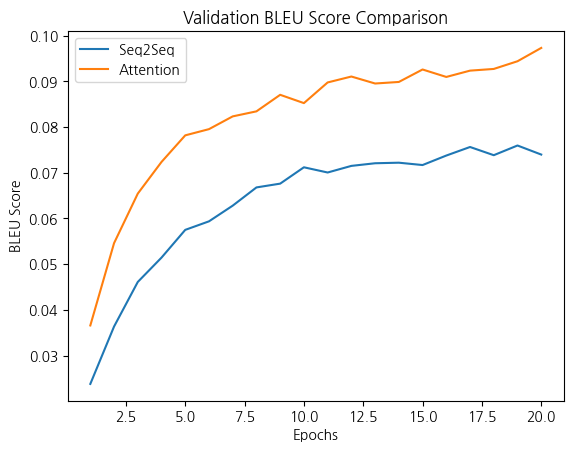

In [54]:
import matplotlib.pyplot as plt

epochs = range(1, CONFIG["epochs"] + 1)

if seq2seq_history:
    seq2seq_bleu = [h["valid_bleu"] for h in seq2seq_history]
    plt.plot(epochs, seq2seq_bleu, label="Seq2Seq")

if attn_history:
    attn_bleu = [h["valid_bleu"] for h in attn_history]
    plt.plot(epochs, attn_bleu, label="Attention")

plt.xlabel("Epochs")
plt.ylabel("BLEU Score")
plt.title("Validation BLEU Score Comparison")
plt.legend()
plt.show()


1. 두 모델 모두 학습이 진행될수록 BLEU가 꾸준히 상승한다.

2. 모든 epoch에서 Attention 모델이 Seq2Seq보다 BLEU가 높다.

3. 다만 절대값은 0.1 미만이라, “전반적인 번역 품질은 아직 낮다”는 점을 보여준다.

“Validation BLEU 기준으로 두 모델 모두 학습 초반에 빠르게 성능이 상승한 뒤 완만히 수렴하는 경향을 보였으며, 모든 epoch에서 Attention 모델이 기본 Seq2Seq보다 약 0.01–0.02 높은 BLEU를 기록했다. 이는 어텐션 메커니즘이 번역 품질 향상에 기여함을 보여주지만, 최종 BLEU가 0.1 이하로 머무는 점에서 추가적인 전처리·모델 구조 개선이 필요함을 시사한다.”

#### 향후 개선
1. 토크나이저 개선

    - 현재 word 단위 → BPE/SentencePiece 기반 subword로 바꾸면 <unk> 감소, 희귀어 처리 개선.

2. 모델/학습 전략

    - teacher forcing 스케줄 조정 (초기 높게, 이후 점진적 감소).
    - dropout 확대(0.2 → 0.3~0.4)로 과적합 완화.
    - 너무 긴 문장에 대해 max_length 조정 및 긴 문장 필터링.

3. 평가 측면

    - BLEU 수치뿐 아니라, 지금처럼 샘플 문장에 대한 정성 평가를 함께 제시하면
    
       “모델이 어디까지 가능한지”를 더 설득력 있게 보여줄 수 있음.